In [1]:
#Imports
import cProfile
import random
import math
import geohash
import geotools
import networkx as nx
import numpy as np
from scipy import spatial,stats
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Geographic Sims</h2>

In [2]:
def generate_nodes(N,pop_min_max,lat_min_max,lon_min_max):
    '''Generate a normally random dictionary of N geographic nodes with data dictionary of node population and lat/lon coords
    N = numer of nodes
    pop_min_max = tuple of [min,max] population thresholds
    lat_min_max = tuple of [min,max] latitude thresholds
    lon_min_max = tuple of [min,max] longitude thresholds
    '''
    
    node_dict = {}
    for node in range(N):
        lat = random.uniform(*lat_min_max)
        lon = random.uniform(*lon_min_max)
        gh = geohash.encode(lat,lon)
        node_dict[gh] = {'pop':random.randint(*pop_min_max),
                           'lat':lat,
                           'lon':lon,
                           'geohash':gh
                          }
    return node_dict

def generate_network(node_dict,max_connect_dist,link_prob):
    seen_edges = []
    G = nx.Graph()
    for node,data in node_dict.items():
        if node not in G.nodes():
            G.add_node(node,attr_dict=data)
        possible_connections = geotools.get_close_ghs(data['geohash'],G.nodes(),max_connect_dist)
        for connection_node in possible_connections:
            edge_hash = ''.join(sorted([node,connection_node]))
            if random.random() <= link_prob and edge_hash not in seen_edges:
                G.add_edge(node,connection_node)
            seen_edges.append(edge_hash)
    return G

In [85]:
node_dict = generate_nodes(10,[10,100],[30.,70],[40,50])
G = generate_network(node_dict,0.1,0.1)

tj89vxxhz4ggtj89vxxhz4gg


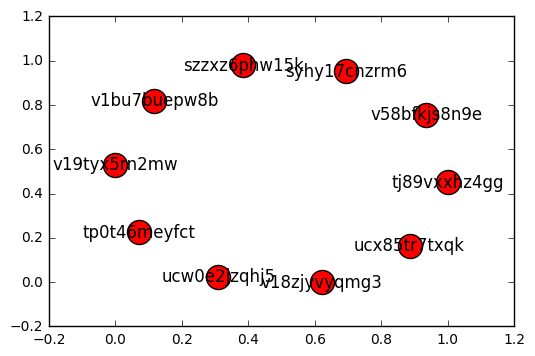

In [86]:
nx.draw_networkx(G)

<h2>Random Geometric Graphs</h2>

In [16]:
def generate_graph_nodes(N,dimensions=2):
    G = nx.Graph()
    for node in range(N):
        pos = [random.random() for dim in range(dimensions)]
        G.add_node(node,pos=pos,weight=random.expovariate(1.0))
    return G

def dynamic_GTG(G,max_distance,alpha,threshold):
    pos_points = list(nx.get_node_attributes(G, 'pos').values())
    point_tree = spatial.cKDTree(pos_points)
    potential_edges = point_tree.query_pairs(max_distance, len(pos_points[0]))
    active_nodes = []
    for edge in potential_edges:
        dist = spatial.distance.euclidean(G.node[edge[0]]['pos'],G.node[edge[1]]['pos'])
        link_value = dist**-alpha
        link_strength = (G.node[edge[0]]['weight']+G.node[edge[0]]['weight'])*link_value
        if link_strength >= threshold(len(active_nodes)):
            G.add_edge(edge[0],edge[1],weight=link_strength)
            if edge[0] not in active_nodes:
                active_nodes.append(edge[0])
            if edge[1] not in active_nodes:
                active_nodes.append(edge[1])                           
    return G

def visualize_GTG(GTG):
    """
    Filename: nx_demo.py
    Authors: John Stachurski and Thomas J. Sargent
    """
    pos = nx.get_node_attributes(GTG, 'pos')    # Get positions of nodes
    plt.figure(figsize=(8,8))
    nx.draw_networkx_edges(GTG, pos, alpha=0.4)
    nx.draw_networkx_nodes(GTG, pos, nodelist=list(GTG.nodes()),
                           node_size=120, alpha=0.5,node_color='blue')
    plt.show()

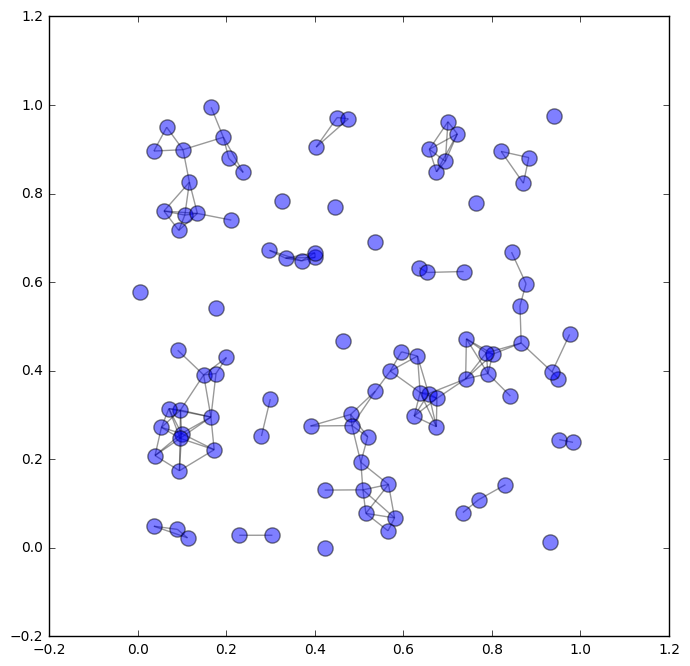

In [17]:
N=100
max_distance = 0.1
test_G = generate_graph_nodes(N)
frz_pos = nx.get_node_attributes(test_G, 'pos')
frz_weight = nx.get_node_attributes(test_G, 'weight') 
test_RGG = nx.generators.geometric.random_geometric_graph(N, max_distance, dim=2, pos=frz_pos)
visualize_GTG(test_RGG)

In [18]:
def dynamic_threshold(N):
    return 1

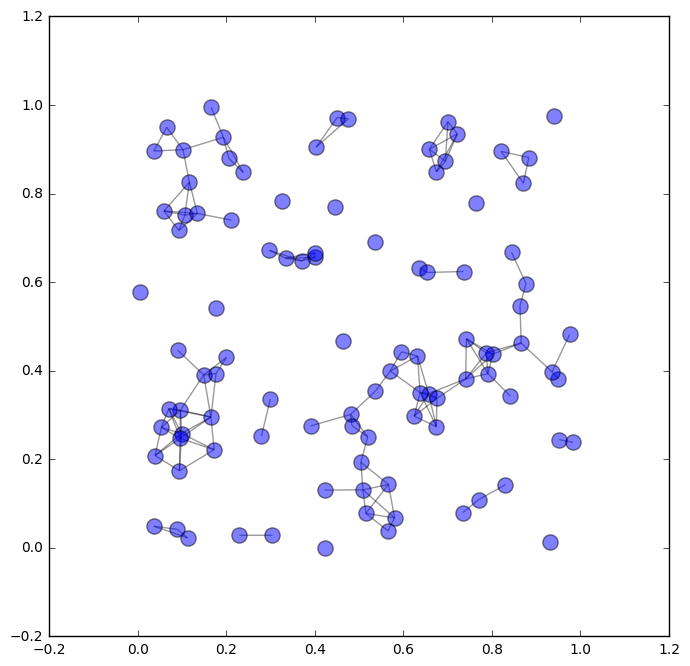

In [19]:
test_DGTG = dynamic_GTG(test_G,max_distance,2,dynamic_threshold)
visualize_GTG(test_DGTG)

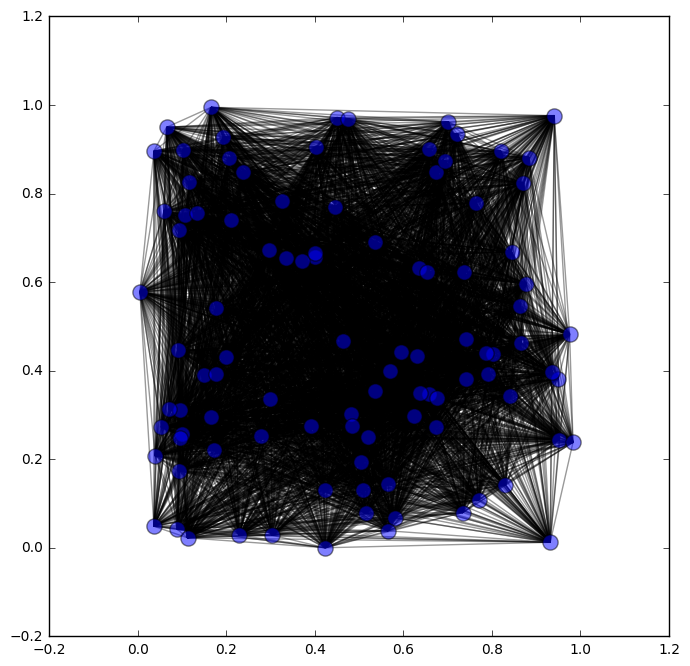

In [21]:
test_GTG = nx.generators.geometric.geographical_threshold_graph(N,1,pos=frz_pos,weight=frz_weight)
visualize_GTG(test_GTG)

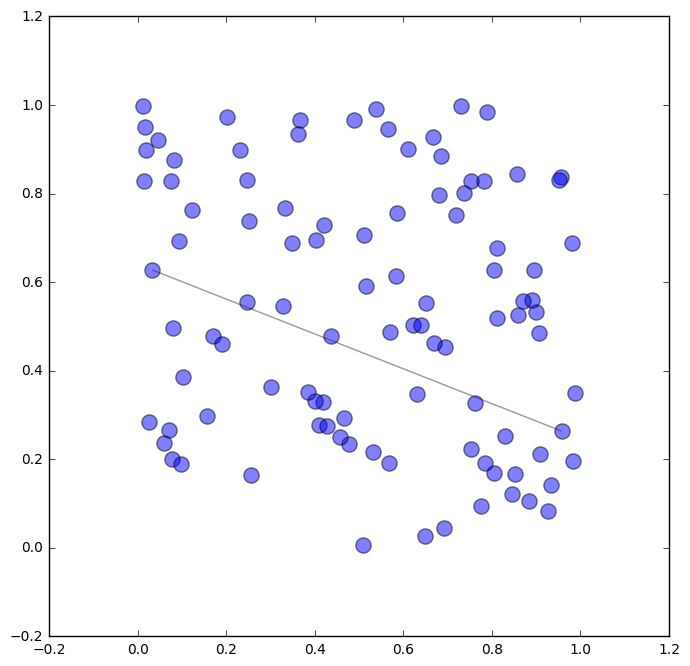

In [16]:
dynamic_GTG = geographical_threshold_graph(100,theta=dynamic_theta,pos=frz_pos,weight=frz_weight,dynamic=True)
visualize_GTG(dynamic_GTG)

In [4]:
def coverage(G,radius,resolution=100):
    half_length = math.floor(radius/(math.sqrt(2)*2))
    grid = np.zeros([resolution,resolution])
    for node,data in G.nodes_iter(data=True):
        top_left = [math.floor(data['pos'][0]*resolution)-half_length,math.floor(data['pos'][1]*resolution)-half_length]
        for x in range(half_length*2):
            for y in range(half_length*2):
                if top_left[0]+x <= resolution-1 and top_left[1] + y <=resolution-1:
                    grid[top_left[0]+x,top_left[1] + y] = 1
    return np.count_nonzero(grid)/resolution**2

In [5]:
def network_profiling(G,radius):
    profile = {0:[0]}
    for N in range(1,len(G)+1):
        profile[N] = []
        sub_graph = G.subgraph(list(profile.keys()))
        biggest_comp = max(nx.connected_component_subgraphs(sub_graph), key=len)
        profile[N].append(coverage(biggest_comp,radius))
    return profile

In [4]:
G=generate_graph_nodes(100)
GTG = distance_weighted_GTG(G.copy(),0.125,0.5,funct='exponential',funct_params=[2])
net_profile = network_profiling(GTG,20)

NameError: name 'network_profiling' is not defined

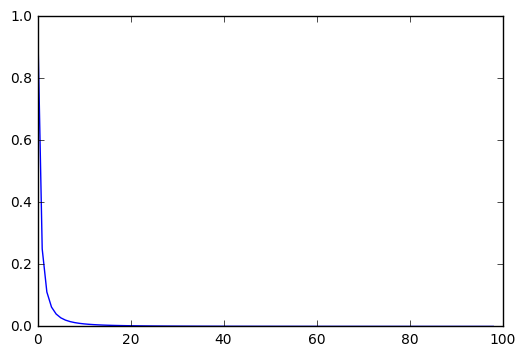

In [6]:
link_prob = []
for i in range(1,100):
    link_prob.append(link_prob_vs_distance(i,100,'exponential',[2]))
plt.plot(link_prob)

<h3>Giant Component</h3>

In [104]:
G=generate_graph_nodes(100)

In [105]:
sim_data = []
threshold=1
for max_distance in range(1,100):
    GTG = distance_weighted_GTG(G.copy(),max_distance/100,threshold,funct='exponential',funct_params=[2])
    biggest_comp = max(nx.connected_component_subgraphs(GTG), key=len)
    sim_data.append([max_distance,threshold,max_distance/threshold,len(biggest_comp)/len(GTG)])

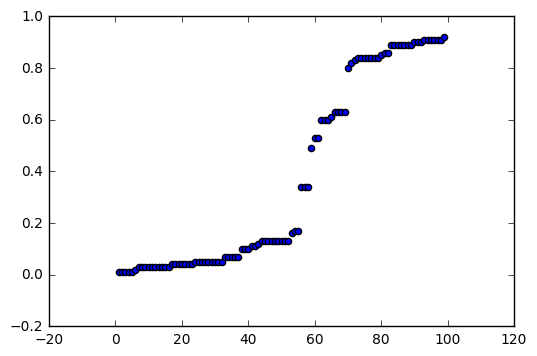

In [106]:
max_distance,threshold,ratio,giant_fraction = zip(*sim_data)
plt.scatter(x=max_distance,y=giant_fraction)

In [63]:
def profile_GTG(N):
    G=generate_graph_nodes(N)
    return distance_weighted_GTG(G,0.125,0.2,funct='unit')